In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation


plt.rc('animation', html='html5')


Done!


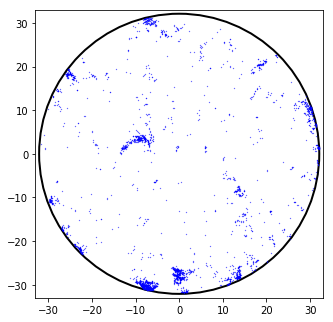

In [ ]:
NumberOfParticles = 3000
Noise_amp = 0.1
ParticlesPerUnit = 3
RadiusSystem = int(np.sqrt( NumberOfParticles/ParticlesPerUnit )) + 1
RatioOfInteraction = 1

Distrib = np.random.poisson(1, NumberOfParticles) + 1
Norm = np.amax(Distrib)  #Распределение
P = 20.*Distrib/Norm
dt=1./15

degree = 2. * np.pi * np.random.random((NumberOfParticles, 1))
degree_pos = 2. * np.pi * np.random.random((NumberOfParticles, 1))
R0 = 0.1+0.9*np.random.random((NumberOfParticles, 1))
Start_velocity_x = (P * np.cos(degree).transpose()).transpose()  # распределение скоростей
Start_velocity_y = (P * np.sin(degree).transpose()).transpose() 

Start_coord_x = RadiusSystem * R0 * np.cos(degree_pos)
Start_coord_y = RadiusSystem * R0 * np.sin(degree_pos) #распределение координат

Velocity = np.column_stack((Start_velocity_x, Start_velocity_y))
Coord = np.column_stack((Start_coord_x, Start_coord_y))
Random_State = np.random.random((NumberOfParticles, 4))
Random_State[:, 2:] = Velocity
Random_State[:, :2] = Coord

init_state = Random_State #Начальное состояние
class ParticleBox:
    def __init__(self,
                init_state=[[1, 0, 0, 1],
                            [-0.5, 0.5, 0.5, 0.5],
                            [-0.5, -0.5, -0.5, 0.5]],
                RadiusSystem=1,
                RatioOfInteraction=1,
                noise = 2*np.pi):
        self.init_state = np.asarray(init_state,dtype=float)
        self.noise = noise
        self.noise_action = 0
        self.state = self.init_state.copy()
        self.RadiusSystem = RadiusSystem
        self.RatioOfInteraction = RatioOfInteraction
        self.R2 = self.RadiusSystem **2
        self.lscl = np.empty(len(self.state[:,0]))
        self.state_orts = self.init_state.copy()
        self.tau = dt * np.ones(len(self.state[:, 0]))
        self.mc = np.arange(3)
        self.time_elapsed = 0
        self.cellv0 = np.array(
            [[self.RadiusSystem - 1, self.RadiusSystem - 1], [0, self.RadiusSystem - 1], [1, self.RadiusSystem - 1],
             [self.RadiusSystem - 1, 0], [0, 0], [1, 0], [self.RadiusSystem - 1, 1], [0, 1], [1, 1]])
        self.cellb = np.empty([self.R2,9])
        self.block = np.empty(self.R2)
        self.block[:] = -1
        self.lscl[:] = -1
        bx=0
        by=0
        for b in range(self.R2):
            for j in range(8):
                bx = self.cellv0[j, 0] + int(b % self.RadiusSystem) 
                by = self.cellv0[j, 0] + int(b // self.RadiusSystem)
                self.cellb[b, j] = int(bx % self.RadiusSystem + (by % self.RadiusSystem) * self.RadiusSystem) #вектор каждой ячейки
    
    def step(self, dt):
        
        self.time_elapsed += dt
        
        self.block[:] = -1
        self.state_orts[:, 2] = np.divide(self.state[:, 2], np.hypot(self.state[:, 2], self.state[:, 3]))
        self.state_orts[:, 3] = np.divide(self.state[:, 3], np.hypot(self.state[:, 2], self.state[:, 3]))

        n0 = 0
        n1 = 0
        Vx = 0
        Vy = 0
        for i in range(len(self.state[:, 0])):
            self.lscl[i] = -1
            b = int(math.floor(np.abs(self.state[i, 0]))) + self.RadiusSystem * int(math.floor(np.abs(self.state[i, 1])))
            self.lscl[i] = self.block[b]
            self.block[b] = i
            
        for b0 in range(self.R2):
            f = int(self.block[b0])  
            while f != -1:
                for b1 in range(8):
                    b2 = int(self.cellb[b0][b1])
                    j = int(self.block[b2])  
                    while j != -1:   #расчет дистанции между частицами в клетках
                        dist = np.sqrt((self.state[f, 0] - self.state[j, 0]) ** 2 + (self.state[f, 1] - self.state[j, 1]) ** 2) 
                        

                        if dist < self.RatioOfInteraction and f != j:
                            n0 += self.state_orts[j, 2]
                            n1 += self.state_orts[j, 3]

                        j = int(self.lscl[j])
                        
                self.noise_action = self.noise * (np.pi - 2  * np.random.rand() * np.pi)
                if (np.abs(n0) < 0.0001) & (np.abs(n1) < 0.0001): #недостаточно сильные взаимодействия не учитываются
                    
                    Vx = self.state_orts[f, 2]
                    Vy = self.state_orts[f, 3]

                    self.state_orts[f, 2] = Vx * np.cos(self.noise_action) - Vy * np.sin(self.noise_action)
                    self.state_orts[f, 3] = Vx * np.sin(self.noise_action) + Vy * np.cos(self.noise_action)
                else:
                    self.state_orts[f, 2] = (n0 * np.cos(self.noise_action) - n1 * np.sin(self.noise_action)) / np.hypot(n0, n1)
                    self.state_orts[f, 3] = (n0 * np.sin(self.noise_action) + n1 * np.cos(self.noise_action)) / np.hypot(n0, n1)

                n0 = 0
                n1 = 0
                self.state[f, 2] = self.state_orts[f, 2]
                self.state[f, 3] = self.state_orts[f, 3]
                #####Периодические условия########
                if (self.state[f, 0] + self.state[f, 2] * dt) ** 2 + (self.state[f, 1] + self.state[f, 3] * dt) ** 2 >= self.RadiusSystem ** 2:

                    
                    x01 = self.state[f, 0] + self.state[f, 2]
                    y01 = self.state[f, 1] + self.state[f, 3]

                    Vx = self.state[f, 2]
                    Vy = self.state[f, 3]

                    self.state[f, 3] = (Vy * (self.RadiusSystem ** 2 - 2. * y01 ** 2) - 2 * Vx * x01 * y01) / self.RadiusSystem ** 2
                    self.state[f, 2] = (Vx * (self.RadiusSystem ** 2 - 2. * x01 ** 2) - 2 * Vy * x01 * y01) / self.RadiusSystem ** 2

                    self.state[f, 0] = self.state[f, 0] + self.state[f, 2] * (dt)
                    self.state[f, 1] = self.state[f, 1] + self.state[f, 3] * (dt)

                    if self.state[f, 0] ** 2 + self.state[f, 1] ** 2 >= self.RadiusSystem ** 2:
                        self.state[f, 0] = x01
                        self.state[f, 1] = y01
    
                else:
                    self.state[f, 0] += dt * self.state[f, 2]
                    self.state[f, 1] += dt * self.state[f, 3]
                            
                f = int(self.lscl[f])
box = ParticleBox(init_state, noise = Noise_amp, RatioOfInteraction=RatioOfInteraction, RadiusSystem=RadiusSystem)            

fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-RadiusSystem - 1, RadiusSystem + 1), ylim=(-RadiusSystem - 1, RadiusSystem + 1))

particles, = ax.plot([], [], 'bo', ms=1)

circ = plt.Circle((0, 0), RadiusSystem + 0.1,fill=False, lw=2)
ax.add_patch(circ)


def init():
    global box
    particles.set_data([], [])   
    return particles, circ


def animate(i):
    global box, dt, ax, fig
    box.step(dt)

    ms = 0.25

    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles.set_markersize(ms)
    return particles,circ 



interval = 10

ani = animation.FuncAnimation(fig, animate, frames=1500,
                              interval=interval, blit=True, init_func=init)


ani.save('particle_box_Viscek.mp4', fps=30)
print("Done!")
plt.show()
ani

In [19]:
cellv0 = np.array(
            [[RadiusSystem - 1, RadiusSystem - 1], [0, RadiusSystem - 1], [1, RadiusSystem - 1],
             [RadiusSystem - 1, 0], [0, 0], [1, 0], [RadiusSystem - 1, 1], [0, 1], [1, 1]])

In [3]:
NumberOfParticles = 10
Distrib = np.random.poisson(1, NumberOfParticles) + 1
Norm = np.amax(Distrib)  #Распределение
P = 20.*Distrib/Norm
dt=1./30

degree = 2. * np.pi * np.random.random((NumberOfParticles, 1))
degree_pos = 2. * np.pi * np.random.random((NumberOfParticles, 1))
R0 = 0.1+0.9*np.random.random((NumberOfParticles, 1))
Start_velocity_x = (P * np.cos(degree).transpose()).transpose() # распределение скорости
Start_velocity_y = (P * np.sin(degree).transpose()).transpose()

In [6]:
Distrib

array([3, 2, 3, 2, 1, 3, 1, 1, 1, 1])

In [31]:
Norm

3

In [32]:
P

array([ 20.        ,  13.33333333,  20.        ,  13.33333333,
         6.66666667,  20.        ,   6.66666667,   6.66666667,
         6.66666667,   6.66666667])

In [33]:
degree

array([[ 0.23849421],
       [ 1.07452707],
       [ 4.2663019 ],
       [ 5.50392193],
       [ 0.89980938],
       [ 0.58191952],
       [ 2.00206999],
       [ 0.07048296],
       [ 4.23593228],
       [ 0.4415164 ]])

array([[ 19.43389608],
       [  6.34864229],
       [ -8.62877679],
       [  9.48575196],
       [  4.14506181],
       [ 16.70818328],
       [ -2.78685454],
       [  6.65011403],
       [ -3.05755599],
       [  6.02736485]])